In [1]:
import xarray as xr
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import os,sys
import random
from skimage.transform import resize
import models
sys.path.insert(0,'/home/huangz78/hydro/unet3d/')
import torch.fft as F
from models.unet3d_model import UNet3D
from models.dnet import weights_init,Discriminator
from models.utils import illustrate, visualization
from train import gan_train,noise_generate
from importlib import reload
from scipy.interpolate import griddata

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
datapath = '/mnt/shared_b/data/hydro_simulations/data/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
print('Total amount of files:', len(ncfiles))
img_size = 320
dep = 8
fileexp_ind = 7736
# val = []
# for fileexp_ind in range(len(ncfiles)):
filename = ncfiles[fileexp_ind]
sim = xr.open_dataarray(datapath+filename)
# val.append(np.max(np.array(sim)[:dep,:,:].flatten()))
sim.close()
dyn   = torch.zeros((1,1,dep,img_size,img_size))    # load one sample, show it
noise = torch.zeros((1,1,dep,img_size,img_size))    # make a noise sample, add it to the ground truth, show it
for t in range(dep):
    dyn[0,0,t,:,:] = torch.tensor( sim.isel(t=t)[:img_size,:img_size].values )

# dyn   = np.zeros((1,1,dep,256,256))    # load one sample, show it
# noise = np.zeros((1,1,dep,256,256))    # make a noise sample, add it to the ground truth, show it
# for t in range(dep):
#     dyn[0,0,t,:,:] = resize(sim.isel(t=t)[:img_size,:img_size].values,(256,256),anti_aliasing=True)

Total amount of files: 13798


# Is denoising in the Fourier domain a good idea?

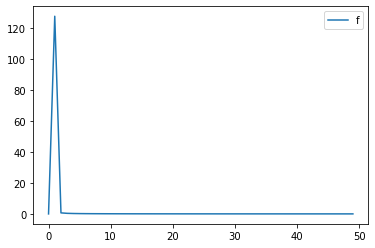

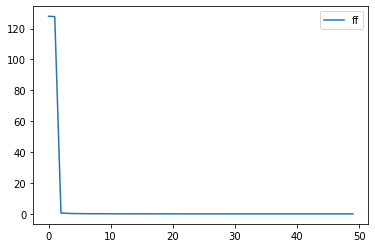

In [12]:
x  = torch.tensor(np.linspace(0,2*np.pi,256))
y  = torch.sin(x)
z  = torch.ones_like(x) * 0.5
yy = y + z

f  = F.fft(y)
ff = F.fft(yy)

plt.figure()
plt.plot(torch.abs(f[0:50]),label='f')
# plt.plot(torch.abs(ff),label='ff')
plt.legend(loc='best')
# plt.yscale('log')
plt.show()

plt.figure()
# plt.plot(torch.abs(f),label='f')
plt.plot(torch.abs(ff[0:50]),label='ff')
plt.legend(loc='best')
# plt.yscale('log')
plt.show()

In [10]:
reload(models.utils)
from models.utils import illustrate, visualization

In [3]:
errordata.files

['g_loss',
 'd_loss',
 'val_loss',
 'nrmse_train',
 'l1_train',
 'nrmse_val',
 'l1_val']

In [15]:
a = torch.randn((2,1,2,320,320))
b = torch.randn((320,320))
(a * b).shape

torch.Size([2, 1, 2, 320, 320])

# check conservation of mass

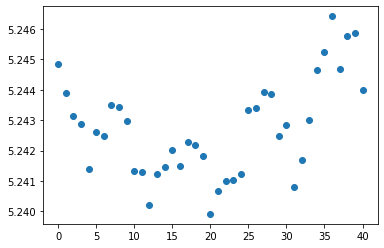

In [10]:
mass = np.zeros(dep)
for ind in range(dep):
    img = dyn[0,0,ind,:,:]
    mass[ind] = integration_over_sphere(img)
plt.scatter(range(dep),mass)
plt.show()

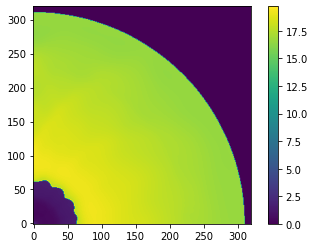

In [5]:
img = dyn[0,0,0,:,:]
plt.imshow(img,origin='lower')
plt.colorbar()
plt.show()

In [16]:
datapath = '/mnt/shared_b/data/hydro_simulations/data/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
print('Total amount of files:', len(ncfiles))
img_size = 320
dep = 41

batchsize = 5
fileexp_inds = [7736+i for i in range(batchsize)]

dyn   = torch.zeros((batchsize,1,dep,img_size,img_size))    # load one sample, show it
noise = torch.zeros((batchsize,1,dep,img_size,img_size))    # make a noise sample, add it to the ground truth, show it

for fileexp_ind in range(len(fileexp_inds)):
    filename = ncfiles[fileexp_inds[fileexp_ind]]
    sim = xr.open_dataarray(datapath+filename)
    # val.append(np.max(np.array(sim)[:dep,:,:].flatten()))
    sim.close()
    for t in range(dep):
        dyn[fileexp_ind,0,t,:,:] = torch.tensor( sim.isel(t=t)[:img_size,:img_size].values )

# dyn   = np.zeros((1,1,dep,256,256))    # load one sample, show it
# noise = np.zeros((1,1,dep,256,256))    # make a noise sample, add it to the ground truth, show it
# for t in range(dep):
#     dyn[0,0,t,:,:] = resize(sim.isel(t=t)[:img_size,:img_size].values,(256,256),anti_aliasing=True)

Total amount of files: 13798


In [24]:
def compute_mass(imgs,Rrho=1,Rz=1):
    '''
    computing through cylindrical coordinate
    '''
    drho = Rrho / imgs.shape[3]
    dz   = Rz   / imgs.shape[4]
    metrics = torch.linspace(0,Rrho,imgs.shape[4]).repeat(imgs.shape[3],1)
    integrand = imgs * metrics
    mass = 2*np.pi * torch.sum(integrand,dim=(3,4)) * drho * dz 
    return torch.squeeze(mass)

In [25]:
compute_mass(dyn)

> <ipython-input-24-455078b5c62c>(6)compute_mass()
      4     '''
      5     breakpoint()
----> 6     drho = Rrho / imgs.shape[3]
      7     dz   = Rz   / imgs.shape[4]
      8 

ipdb> unt 11
> <ipython-input-24-455078b5c62c>(11)compute_mass()
      8 
      9     metrics = torch.linspace(0,Rrho,imgs.shape[4]).repeat(imgs.shape[3],1)
     10     integrand = imgs * metrics
---> 11     mass = 2*np.pi * torch.sum(integrand,dim=(3,4)) * drho * dz
     12     return torch.squeeze(mass)

ipdb> n
> <ipython-input-24-455078b5c62c>(12)compute_mass()
      8 
      9     metrics = torch.linspace(0,Rrho,imgs.shape[4]).repeat(imgs.shape[3],1)
     10     integrand = imgs * metrics
     11     mass = 2*np.pi * torch.sum(integrand,dim=(3,4)) * drho * dz
---> 12     return torch.squeeze(mass)

ipdb> p torch.squeeze(mass).shape
torch.Size([5, 41])
ipdb> q


BdbQuit: 

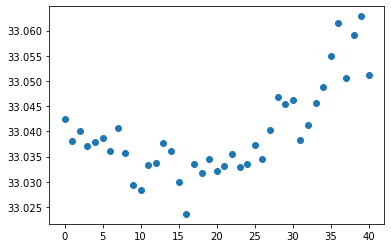

In [13]:
mass = np.zeros(dep)
for ind in range(dep):
    img = dyn[0,0,ind,:,:]
    mass[ind] = compute_mass(img)
plt.scatter(range(dep),mass)
plt.show()

In [ ]:
def compute_mass(rho, R, z):
    dR = R[1] - R[0]
    dz = z[1] - z[0]
    m = sum(2*np.pi*R[:]*rho[:])*dR*dz
    return m

In [44]:
grid_r, grid_theta = np.mgrid[0:1:301j, np.pi/2:np.pi:301j]

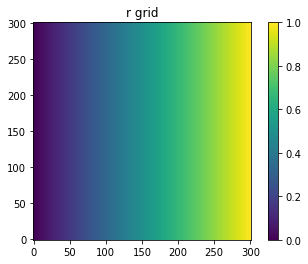

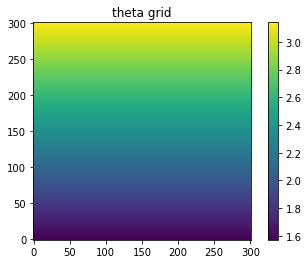

In [76]:
plt.imshow(grid_r.T,origin='lower')
plt.colorbar()
plt.title('r grid')
plt.show()

plt.imshow(grid_theta.T,origin='lower')
plt.colorbar()
plt.title('theta grid')
plt.show()

In [18]:
def integration_over_sphere(img,img_size=320,grid_len=300,method='cubic',R=1,Rx=1,Ry=1):
    
    grid_r, grid_theta = np.mgrid[0:R:301j, np.pi/2:np.pi:301j]
    dr = 1/grid_len
    dtheta = np.pi/(2*grid_len)
    Cartesian_grid = [[i/img_size*Rx,j/img_size*Ry] for i in range(img_size) for j in range(img_size)]
    radius = lambda x,y: np.sqrt(x**2 + y**2)
    theta  = lambda x,y: np.arctan(x/y) + np.pi/2
    
    Spherical_grid = []
    vals = []
    for point in Cartesian_grid:
        if point[0]==0:
            Spherical_grid.append([point[1],np.pi/2])
        elif (point[1]==0) and (point[0]!=0):
            Spherical_grid.append([point[0],np.pi])
        else:
            Spherical_grid.append([radius(point[0],point[1]),theta(point[0],point[1])])
        vals.append(img[int(point[0]*img_size/Rx),int(point[1]*img_size/Ry)])
        
    Spherical_grid = np.array(Spherical_grid)
#     Cartesian_grid = np.array(Cartesian_grid)
    vals = np.array(vals)

    den_interp = griddata(Spherical_grid, vals, (grid_r, grid_theta), method=method).T
    metric = (grid_r.T)**2 * np.sin(grid_theta.T)
    
    mass = np.sum(metric * np.nan_to_num(den_interp)) * dr * dtheta
    
    return mass

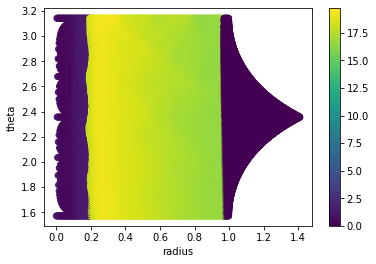

In [75]:
plt.scatter(Spherical_grid[:,0],Spherical_grid[:,1],c=vals)
plt.xlabel('radius')
plt.ylabel('theta')
plt.colorbar()
plt.show()

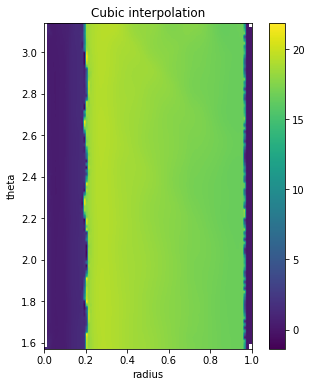

In [23]:
plt.imshow(den_interp.T, extent=(0,1,np.pi/2,np.pi), origin='lower')
plt.title('Cubic interpolation')
plt.gcf().set_size_inches(6, 6)
plt.colorbar()
plt.xlabel('radius')
plt.ylabel('theta')
plt.show()

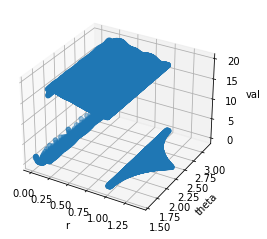

In [33]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Spherical_grid[:,0],Spherical_grid[:,1],vals)
ax.set_xlabel('r')
ax.set_ylabel('theta')
ax.set_zlabel('val')
plt.show()

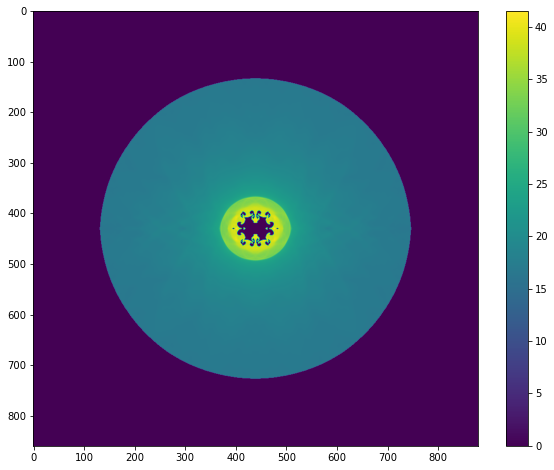

In [24]:
dyn = np.loadtxt('/home/huangz78/hydro/leo1_trada.txt')
heg = 860
wid = 880
dx = 2.558140 * 1e-2 
dy = 2.500000 * 1e-2
dyn = np.reshape(dyn,(heg,wid))
Rx = dx * 320
Ry = dy * 320
R  = min(Rx,Ry)

plt.figure(figsize=(10,8))
plt.imshow(dyn)
plt.colorbar()
plt.show()

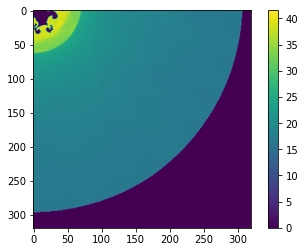

In [25]:
imgslice = dyn[heg//2:heg//2+320,wid//2:wid//2+320]
plt.imshow(imgslice)
plt.colorbar()
plt.show()

In [26]:
integration_over_sphere(imgslice,R=R,Rx=Rx,Ry=Ry)

326.62647290951725

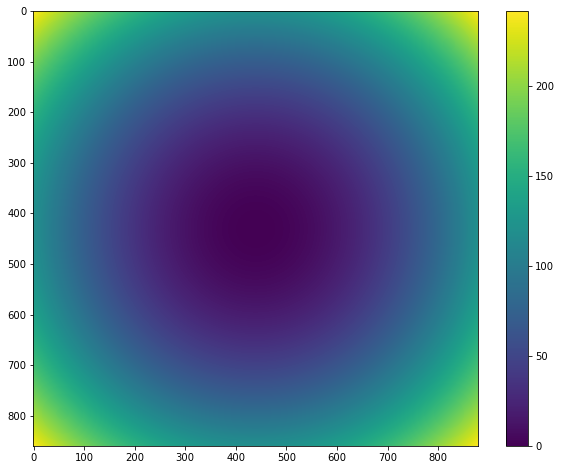

384076.717677827


In [44]:
heg = 860
wid = 880
dx = 2.558140 * 1e-2 
dy = 2.500000 * 1e-2

weights = np.array([[i**2+j**2 for j in (np.arange(0,wid)-wid//2)*dy] for i in (np.arange(0,heg)-heg//2)*dx])
plt.figure(figsize=(10,8))
plt.imshow(weights)
plt.colorbar()
plt.show()

summation = np.sum(np.multiply(weights,dyn))*(dx*dy)*4/3*np.pi
print(summation)

# summation = np.zeros((dep))
# for t in range(dep):
#     summation[t] = np.sum(np.multiply(weights,dyn[0,0,t,:,:]))
# plt.figure()
# plt.scatter(range(dep),summation)
# plt.xlabel('frame number')
# plt.ylabel('weighted summation of pixels')
# plt.show()

Total amount of files: 13798


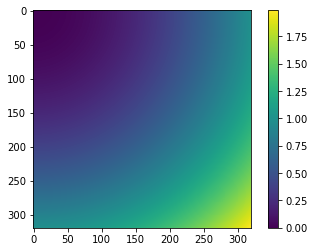

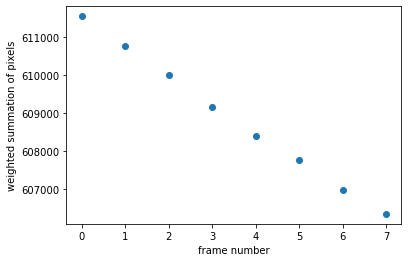

In [13]:
weights = np.array([[i**2+j**2 for i in np.arange(0,img_size)/img_size] for j in np.arange(0,img_size)/img_size])
plt.figure()
plt.imshow(weights)
plt.colorbar()
plt.show()

summation = np.zeros((dep))
for t in range(dep):
    summation[t] = np.sum(np.multiply(weights,dyn[0,0,t,:,:]))
plt.figure()
plt.scatter(range(dep),summation)
plt.xlabel('frame number')
plt.ylabel('weighted summation of pixels')
plt.show()

# track adversial training errors

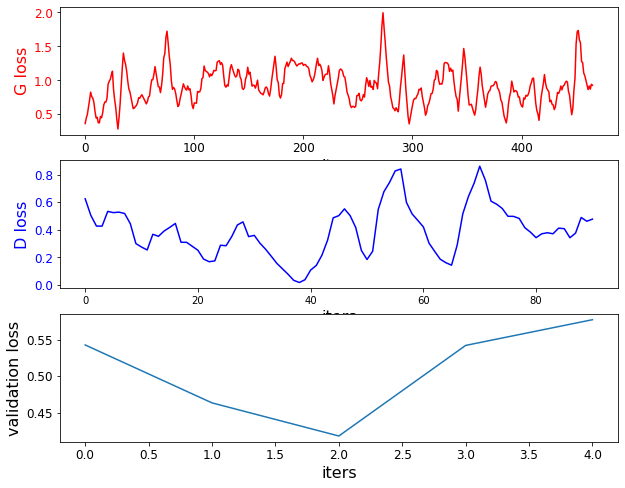

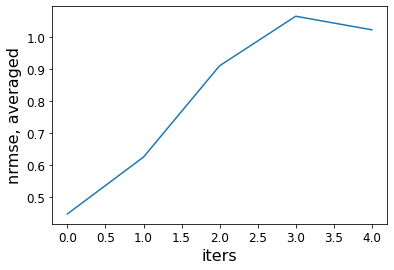

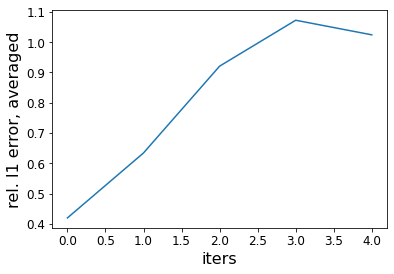

In [4]:
errorRec_path = '/home/huangz78/checkpoints/gan_train_track.npz'
errordata = np.load(errorRec_path)
%matplotlib inline
visualization(errordata['g_loss'],errordata['d_loss'],errordata['val_loss'],\
              errordata['nrmse_val'],errordata['l1_val'],\
              log_loss=False,log_val=False,log_err=False,window=5)

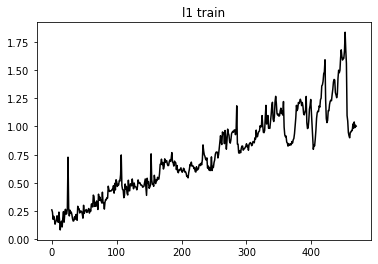

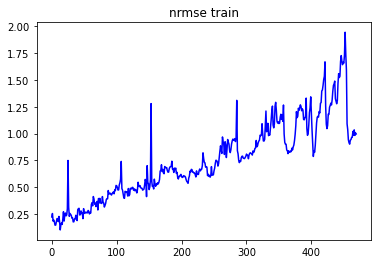

In [5]:
plt.figure(figsize=(6,4))
plt.plot(errordata['l1_train'],'k')
plt.title('l1 train')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(errordata['nrmse_train'],'b')
plt.title('nrmse train')
plt.show()

# check denoised slices

/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


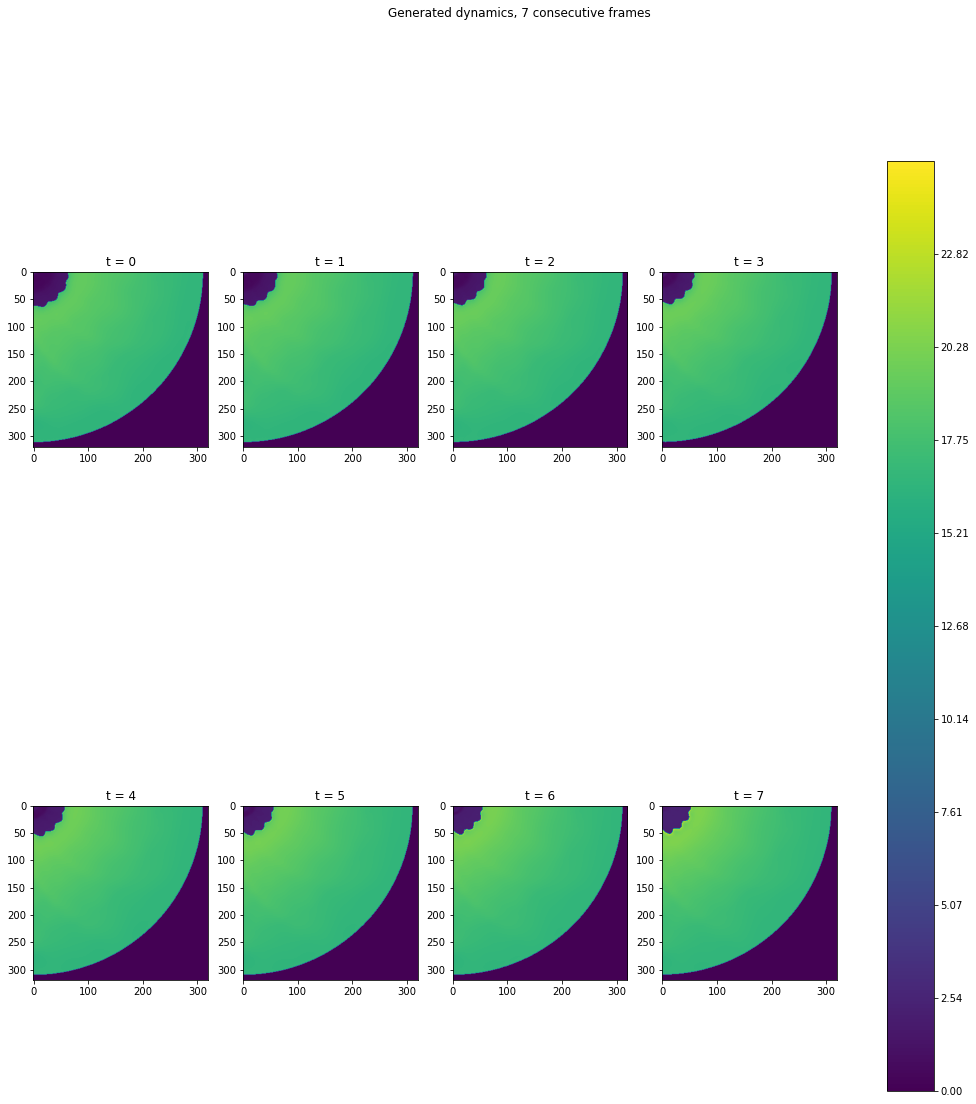

In [6]:
# normalize_factor   = np.max( np.abs(dyn[0,0,:,:,:]).flatten() )
# normalize_factor   = 50
# dyn[0,0,:,:,:]  = dyn[0,0,:,:,:] / normalize_factor
for t in range(dep): # different noise for each frame when using a 'for' loop
    noise[0,0,t,:,:] = noise_generate(dyn[0,0,t,:,:],mode='linear') 
dyn = torch.tensor(dyn).to(torch.float); noise = torch.tensor(noise).to(torch.float)

%matplotlib inline
illustrate(dyn,vmin=-np.inf,vmax=np.inf)
# illustrate(noise + dyn)

In [13]:
# load a G net
gnet = UNet3D(1,1,is_segmentation=False,final_sigmoid=False)
gpath = '/home/huangz78/checkpoints/netG.pth'
# gpath = '/home/huangz78/checkpoints/netG_warmup.pth'
checkpoint = torch.load(gpath)
gnet.load_state_dict(checkpoint['model_state_dict'])
print(f'G net loaded from {gpath}')

RuntimeError: Error(s) in loading state_dict for UNet3D:
	Missing key(s) in state_dict: "encoders.0.basic_module.SingleConv1.groupnorm.weight", "encoders.0.basic_module.SingleConv1.groupnorm.bias", "encoders.0.basic_module.SingleConv1.conv.weight", "encoders.0.basic_module.SingleConv2.groupnorm.weight", "encoders.0.basic_module.SingleConv2.groupnorm.bias", "encoders.0.basic_module.SingleConv2.conv.weight", "encoders.1.basic_module.SingleConv1.groupnorm.weight", "encoders.1.basic_module.SingleConv1.groupnorm.bias", "encoders.1.basic_module.SingleConv1.conv.weight", "encoders.1.basic_module.SingleConv2.groupnorm.weight", "encoders.1.basic_module.SingleConv2.groupnorm.bias", "encoders.1.basic_module.SingleConv2.conv.weight", "encoders.2.basic_module.SingleConv1.groupnorm.weight", "encoders.2.basic_module.SingleConv1.groupnorm.bias", "encoders.2.basic_module.SingleConv1.conv.weight", "encoders.2.basic_module.SingleConv2.groupnorm.weight", "encoders.2.basic_module.SingleConv2.groupnorm.bias", "encoders.2.basic_module.SingleConv2.conv.weight", "encoders.3.basic_module.SingleConv1.groupnorm.weight", "encoders.3.basic_module.SingleConv1.groupnorm.bias", "encoders.3.basic_module.SingleConv1.conv.weight", "encoders.3.basic_module.SingleConv2.groupnorm.weight", "encoders.3.basic_module.SingleConv2.groupnorm.bias", "encoders.3.basic_module.SingleConv2.conv.weight", "decoders.0.basic_module.SingleConv1.groupnorm.weight", "decoders.0.basic_module.SingleConv1.groupnorm.bias", "decoders.0.basic_module.SingleConv1.conv.weight", "decoders.0.basic_module.SingleConv2.groupnorm.weight", "decoders.0.basic_module.SingleConv2.groupnorm.bias", "decoders.0.basic_module.SingleConv2.conv.weight", "decoders.1.basic_module.SingleConv1.groupnorm.weight", "decoders.1.basic_module.SingleConv1.groupnorm.bias", "decoders.1.basic_module.SingleConv1.conv.weight", "decoders.1.basic_module.SingleConv2.groupnorm.weight", "decoders.1.basic_module.SingleConv2.groupnorm.bias", "decoders.1.basic_module.SingleConv2.conv.weight", "decoders.2.basic_module.SingleConv1.groupnorm.weight", "decoders.2.basic_module.SingleConv1.groupnorm.bias", "decoders.2.basic_module.SingleConv1.conv.weight", "decoders.2.basic_module.SingleConv2.groupnorm.weight", "decoders.2.basic_module.SingleConv2.groupnorm.bias", "decoders.2.basic_module.SingleConv2.conv.weight". 
	Unexpected key(s) in state_dict: "encoders.0.basic_module.conv1.groupnorm.weight", "encoders.0.basic_module.conv1.groupnorm.bias", "encoders.0.basic_module.conv1.conv.weight", "encoders.0.basic_module.conv2.groupnorm.weight", "encoders.0.basic_module.conv2.groupnorm.bias", "encoders.0.basic_module.conv2.conv.weight", "encoders.0.basic_module.conv3.groupnorm.weight", "encoders.0.basic_module.conv3.groupnorm.bias", "encoders.0.basic_module.conv3.conv.weight", "encoders.1.basic_module.conv1.groupnorm.weight", "encoders.1.basic_module.conv1.groupnorm.bias", "encoders.1.basic_module.conv1.conv.weight", "encoders.1.basic_module.conv2.groupnorm.weight", "encoders.1.basic_module.conv2.groupnorm.bias", "encoders.1.basic_module.conv2.conv.weight", "encoders.1.basic_module.conv3.groupnorm.weight", "encoders.1.basic_module.conv3.groupnorm.bias", "encoders.1.basic_module.conv3.conv.weight", "encoders.2.basic_module.conv1.groupnorm.weight", "encoders.2.basic_module.conv1.groupnorm.bias", "encoders.2.basic_module.conv1.conv.weight", "encoders.2.basic_module.conv2.groupnorm.weight", "encoders.2.basic_module.conv2.groupnorm.bias", "encoders.2.basic_module.conv2.conv.weight", "encoders.2.basic_module.conv3.groupnorm.weight", "encoders.2.basic_module.conv3.groupnorm.bias", "encoders.2.basic_module.conv3.conv.weight", "encoders.3.basic_module.conv1.groupnorm.weight", "encoders.3.basic_module.conv1.groupnorm.bias", "encoders.3.basic_module.conv1.conv.weight", "encoders.3.basic_module.conv2.groupnorm.weight", "encoders.3.basic_module.conv2.groupnorm.bias", "encoders.3.basic_module.conv2.conv.weight", "encoders.3.basic_module.conv3.groupnorm.weight", "encoders.3.basic_module.conv3.groupnorm.bias", "encoders.3.basic_module.conv3.conv.weight", "decoders.0.upsampling.upsample.weight", "decoders.0.upsampling.upsample.bias", "decoders.0.basic_module.conv1.groupnorm.weight", "decoders.0.basic_module.conv1.groupnorm.bias", "decoders.0.basic_module.conv1.conv.weight", "decoders.0.basic_module.conv2.groupnorm.weight", "decoders.0.basic_module.conv2.groupnorm.bias", "decoders.0.basic_module.conv2.conv.weight", "decoders.0.basic_module.conv3.groupnorm.weight", "decoders.0.basic_module.conv3.groupnorm.bias", "decoders.0.basic_module.conv3.conv.weight", "decoders.1.upsampling.upsample.weight", "decoders.1.upsampling.upsample.bias", "decoders.1.basic_module.conv1.groupnorm.weight", "decoders.1.basic_module.conv1.groupnorm.bias", "decoders.1.basic_module.conv1.conv.weight", "decoders.1.basic_module.conv2.groupnorm.weight", "decoders.1.basic_module.conv2.groupnorm.bias", "decoders.1.basic_module.conv2.conv.weight", "decoders.1.basic_module.conv3.groupnorm.weight", "decoders.1.basic_module.conv3.groupnorm.bias", "decoders.1.basic_module.conv3.conv.weight", "decoders.2.upsampling.upsample.weight", "decoders.2.upsampling.upsample.bias", "decoders.2.basic_module.conv1.groupnorm.weight", "decoders.2.basic_module.conv1.groupnorm.bias", "decoders.2.basic_module.conv1.conv.weight", "decoders.2.basic_module.conv2.groupnorm.weight", "decoders.2.basic_module.conv2.groupnorm.bias", "decoders.2.basic_module.conv2.conv.weight", "decoders.2.basic_module.conv3.groupnorm.weight", "decoders.2.basic_module.conv3.groupnorm.bias", "decoders.2.basic_module.conv3.conv.weight". 

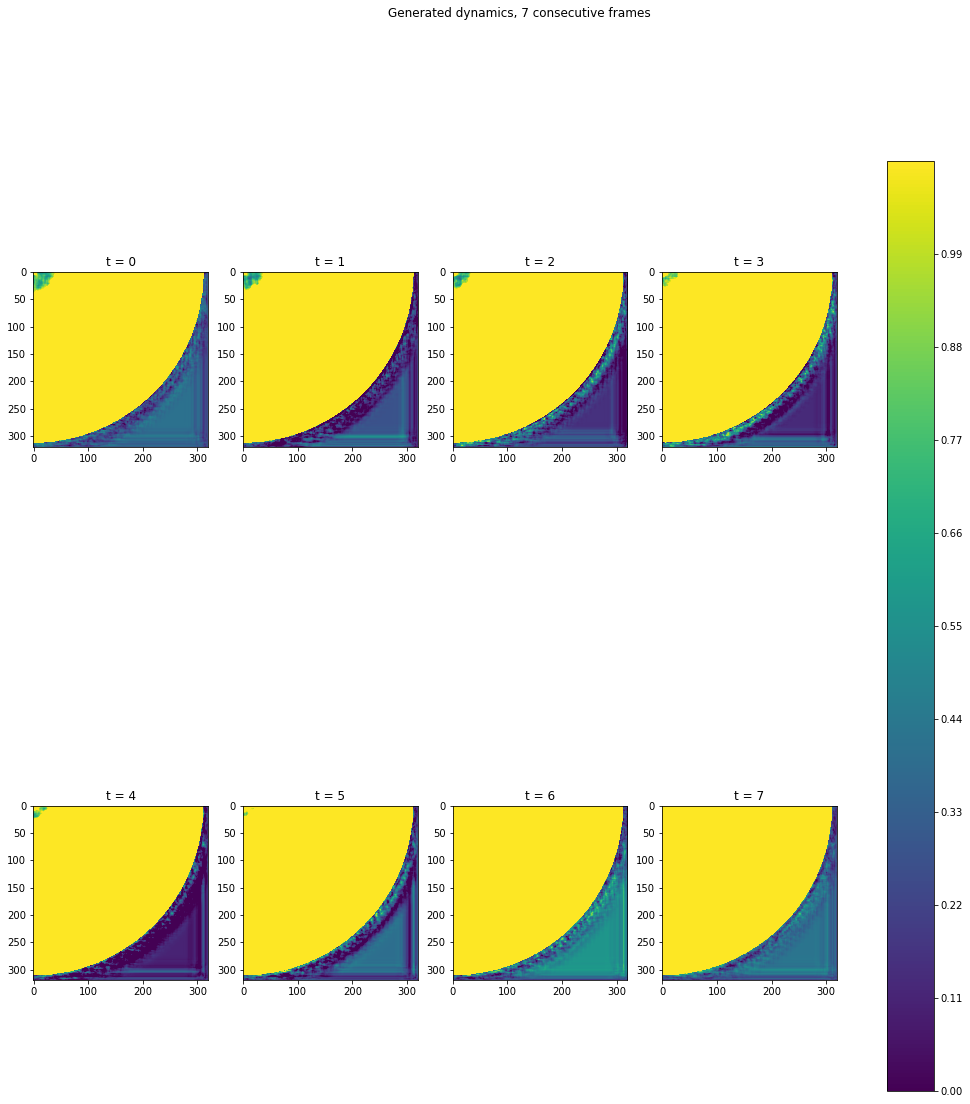

In [8]:
# apply denoiser, show the outcome
noisy_dyn     = noise + dyn
denoised_samp = gnet(noisy_dyn)
illustrate(denoised_samp)